In [ ]:
#pip install tweepy textblob matplotlib wordcloud googletrans unidecode

In [37]:
import tweepy
from textblob import TextBlob
from wordcloud import WordCloud
import pandas as pd
import numpy as np
import re
import matplotlib.pyplot as plt
plt.style.use('fivethirtyeight')
from googletrans import Translator
from unidecode import unidecode
import seaborn as sns
import credenciais_twitter as crd#importando as credenciais de outro arquivo

In [38]:
##login

In [39]:
consumerKey = crd.consumerKey
consumerSecret = crd.consumerSecret
accessToken = crd.accessToken
accessTokenSecret = crd.accessTokenSecret

In [40]:
#Criando nossa autenticação
auth = tweepy.OAuthHandler(consumerKey,consumerSecret)
#"Direcionando" o token de acesso
auth.set_access_token(accessToken, accessTokenSecret) 
#criando o objeto da API usando nossas credenciais
api = tweepy.API(auth, wait_on_rate_limit = True)

In [56]:
name_id = 'billgates'
language = 'en'

In [57]:
# Fazendo um scrapping dos ultimos 100 tweets
posts = api.user_timeline(screen_name=name_id,
                          count = 100,
                          lang =language,
                          tweet_mode="extended")


In [58]:
#Criando uma lista (usando list comprehension) para inserirmos num DataFrame
df_tweets=pd.DataFrame([tweet.full_text for tweet in posts], columns=['Tweets'])
df_tweets.head()

,Tweets
0,"If we learn the lessons of COVID-19, we can ap..."
1,"In his final words, John Lewis challenges all ..."
2,The impacts of COVID-19 are driving worrying i...
3,RT @trevormundel: The @WorldBank’s support of ...
4,"In these challenging times, we can’t lose sigh..."


In [59]:
def limpando_chars(text):
    text = re.sub('@[A-Za-z0–9]+', '', text) #removendo @
    text = re.sub('#', '', text) #removendo #
    text = re.sub('RT[\s]+', '', text) # Removendo RT
    text = re.sub('https?:\/\/\S+', '', text) # Removendo hyperlink
    text = re.sub('&amp','', text)# removendo marcação HTML de início
    return text

In [60]:
#limpando os tweets com a função criada
df_tweets['Tweets'] = df_tweets['Tweets'].apply(limpando_chars)

In [61]:
# Função que analisa e obtém a subjetividade
def capture_subjetividade_pt(text):
    return TextBlob(text).sentiment.subjectivity
# Função que analisa e obtém a polaridade
def capture_polaridade_pt(text):
    return  TextBlob(text).sentiment.polarity
def translate_text(text):
        return Translator().translate(unidecode(text)).text
#Traduzindo
if language!= 'en':
    df_tweets['Tweets'] = df_tweets['Tweets'].apply(translate_text)
else:
    pass
# Criar duas colunas de subjetividade e polaridade

df_tweets['Subjetividade'] = df_tweets['Tweets'].apply(capture_polaridade_pt)
df_tweets['Polaridade'] = df_tweets['Tweets'].apply(capture_subjetividade_pt)

# Mostra um novo dataframe com as colunas subjetividade e polaridade
df_tweets.tail()

,Tweets,Subjetividade,Polaridade
95,"In our new annual letter, and I write about w...",0.128788,0.304293
96,: The world must work together to slow the cor...,-0.100000,0.466667
97,Roger’s foundation partners with local NGOs...,0.225000,0.279167
98,I’m excited to team up with again for the Mat...,0.375000,0.750000
99,As we conclude our foundation’s second decade ...,0.166667,0.166667


In [62]:
#-1 negativo
#0 neutro
#1 positivo
def gerar_analise(score):
    if score < 0:
        return 'Negativo'
    elif score == 0:
        return 'Neutro'
    else:
        return 'Positivo'
df_tweets['Analise'] = df_tweets['Polaridade'].apply(gerar_analise)

In [63]:
# Printando apenas os tweets positivos 
print('Printing positive tweets:\n')
j=1
sortedDF = df_tweets.sort_values(by=['Polaridade']) #ordenando os tweets
for i in range(0, sortedDF.shape[0] ):
    if( sortedDF['Analise'][i] == 'Positivo'):
        print(str(j) + ') '+ sortedDF['Tweets'][i])
        print()
        j= j+1

Printing positive tweets:

1) If we learn the lessons of COVID-19, we can approach climate change more informed about the consequences of inaction, and more prepared to save lives and prevent the worst possible outcome. 

2) In his final words, John Lewis challenges all of us to continue to stand up for what we truly believe. “Together, you can redeem the soul of our nation.” 



3) The impacts of COVID-19 are driving worrying increases in malnutrition and health outcomes. However, there are clear actions that can be taken in both the near- and long-term. 

4) In these challenging times, we can’t lose sight of the importance of combatting climate change. I’m excited to hear about how companies like  are finding a way to play a role. 

5) It’s important that we continue to follow scientific data as we look for new tools to aid in the fight against coronavirus.  

6) It’s hard to overstate how important finding a reliable, affordable, and easy-to-use diagnostic is for stopping Alzheimer’

In [64]:
# Printando apenas os tweets negativos 
print('Printing negative tweets:\n')
j=1
sortedDF = df_tweets.sort_values(by=['Polaridade'],ascending=False) #ordenando os tweets
for i in range(0, sortedDF.shape[0] ):
    if( sortedDF['Analise'][i] == 'Negativo'):
        print(str(j) + ') '+sortedDF['Tweets'][i])
        print()
        j=j+1

Printing negative tweets:



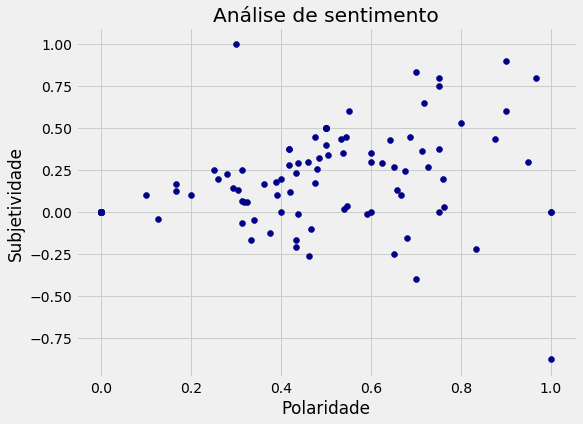

In [65]:
# Plotting 
plt.figure(figsize=(8,6)) 
for i in range(0, df_tweets.shape[0]):
    plt.scatter(df_tweets["Polaridade"][i], df_tweets["Subjetividade"][i], color='darkblue') 
plt.title('Análise de sentimento') 
plt.xlabel('Polaridade') 
plt.ylabel('Subjetividade') 
plt.show()

In [66]:
#% de tweets positivos
ptweets = df_tweets[df_tweets.Analise == 'Positivo']
ptweets = ptweets['Tweets']
ptweets

round( (ptweets.shape[0] / df_tweets.shape[0]) * 100 , 1)

87.0

In [67]:
#% de tweets negativos
ntweets = df_tweets[df_tweets.Analise == 'Negativo']
ntweets = ntweets['Tweets']
ntweets

round( (ntweets.shape[0] / df_tweets.shape[0]) * 100, 1)

0.0

In [68]:
df = pd.DataFrame(df_tweets['Analise'].value_counts())

Text(0, 0.5, 'Sentimento')

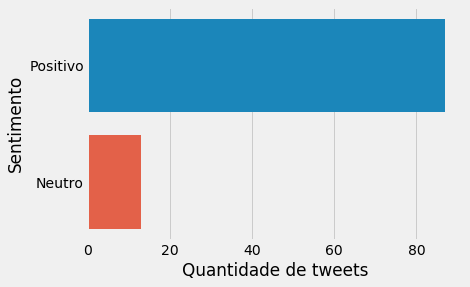

In [69]:
plt.figure()
ax = sns.barplot(x=df['Analise'], y=df.index, data=df_tweets)
ax.set_xlabel('Quantidade de tweets')
ax.set_ylabel('Sentimento')

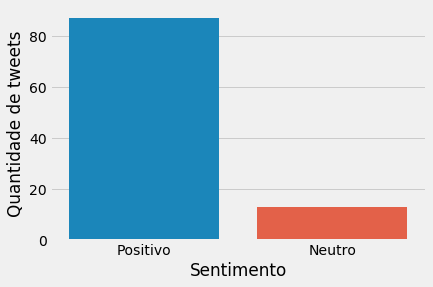

In [70]:
ax = sns.barplot(x=df.index, y=df['Analise'],data=df_tweets,label='Quantidade de Tweets')
ax.set_ylabel('Quantidade de tweets')
ax.set_xlabel('Sentimento');